In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

from astropy import table
from astropy.table import Table
from astropy.io import ascii
from astropy.io import fits
from astropy import wcs

import matplotlib.image as mpimg

import matplotlib.ticker as ticker
from matplotlib.patches import Circle
from matplotlib.patches import Ellipse

SAGA_DIR = os.environ['SAGA_DIR']


In [2]:
from palettable.colorbrewer.qualitative import Dark2_8
if 'plt' in locals() and hasattr(plt, 'rcParams'):
    plt.rcParams['lines.linewidth'] = 2.0
    plt.rcParams['font.size'] = 15.0
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=Dark2_8.mpl_colors)
    plt.rcParams['legend.fontsize'] = 'medium'
    plt.rcParams['legend.frameon'] = False
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['figure.figsize'] = 28, 18
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['xtick.minor.size'] = 4
    plt.rcParams['ytick.major.size'] = 6
    plt.rcParams['ytick.minor.size'] = 4

In [3]:
# READ SPECTRA
file = SAGA_DIR +'/data/saga_spectra_clean.fits.gz'
allspec = Table.read(file)
complete_hosts =[147100,166313,165536,61945,149781,33446,150887,132339]
# SORTED BY K-BAND
complete_hosts =[150887,147100,149781, 166313,165536,33446,132339,61945]



In [4]:
# GENERAL MASKS
m_rmv  = allspec['REMOVE'] == -1
m_fib  = allspec['FIBERMAG_R'] <= 23
m_gal  = allspec['PHOT_SG'] == 'GALAXY'
m_sats = allspec['SATS'] == 1

dmod1 = 5.* np.log10(allspec['HOST_DIST'] * 1e6) - 5.
dmod = 5.*np.log10(1e6 * allspec['SPEC_Z']*3e5/70.) - 5.
Mr = allspec['r']- allspec['EXTINCTION_R'] - dmod
m_abs_mr = Mr < -12.3

/Users/marlageha/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/marlageha/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: invalid value encountered in log10


In [5]:
def get_sdss_image(nsaid,obj):
    sdss_image_scale = 3*obj['PETRORAD_R']/512.*2.
    sdss_jpg_file = np.str(nsaid) + '.jpg'

    RA = np.str(obj['RA'])
    print RA
    sdssurl = 'http://skyservice.pha.jhu.edu/DR10/ImgCutout/getjpeg.aspx?ra=' + np.str(obj['RA']) + '&dec=' +  np.str(obj['DEC']) +'&width=512&height=512&scale=' + np.str(sdss_image_scale)
    #urllib.urlretrieve(sdssurl, sdss_jpg_file)
    #img = mpimg.imread(sdss_jpg_file)
#    print sdssurl
    return img


150887 0.464326482334 5
NGC 7541
1
147100 0.500844952406 9
NGC 6181
0
149781 0.438762576186 4
PGC 68743
0
166313 0.613448117949 2
NGC 5962
0
165536 0.676929298557 1
NGC 5750
0
33446 0.455481169815 2
NGC 2543
0
132339 0.462627498883 2
NGC 1015
0
61945 0.494398151925 2
NGC 7716
0


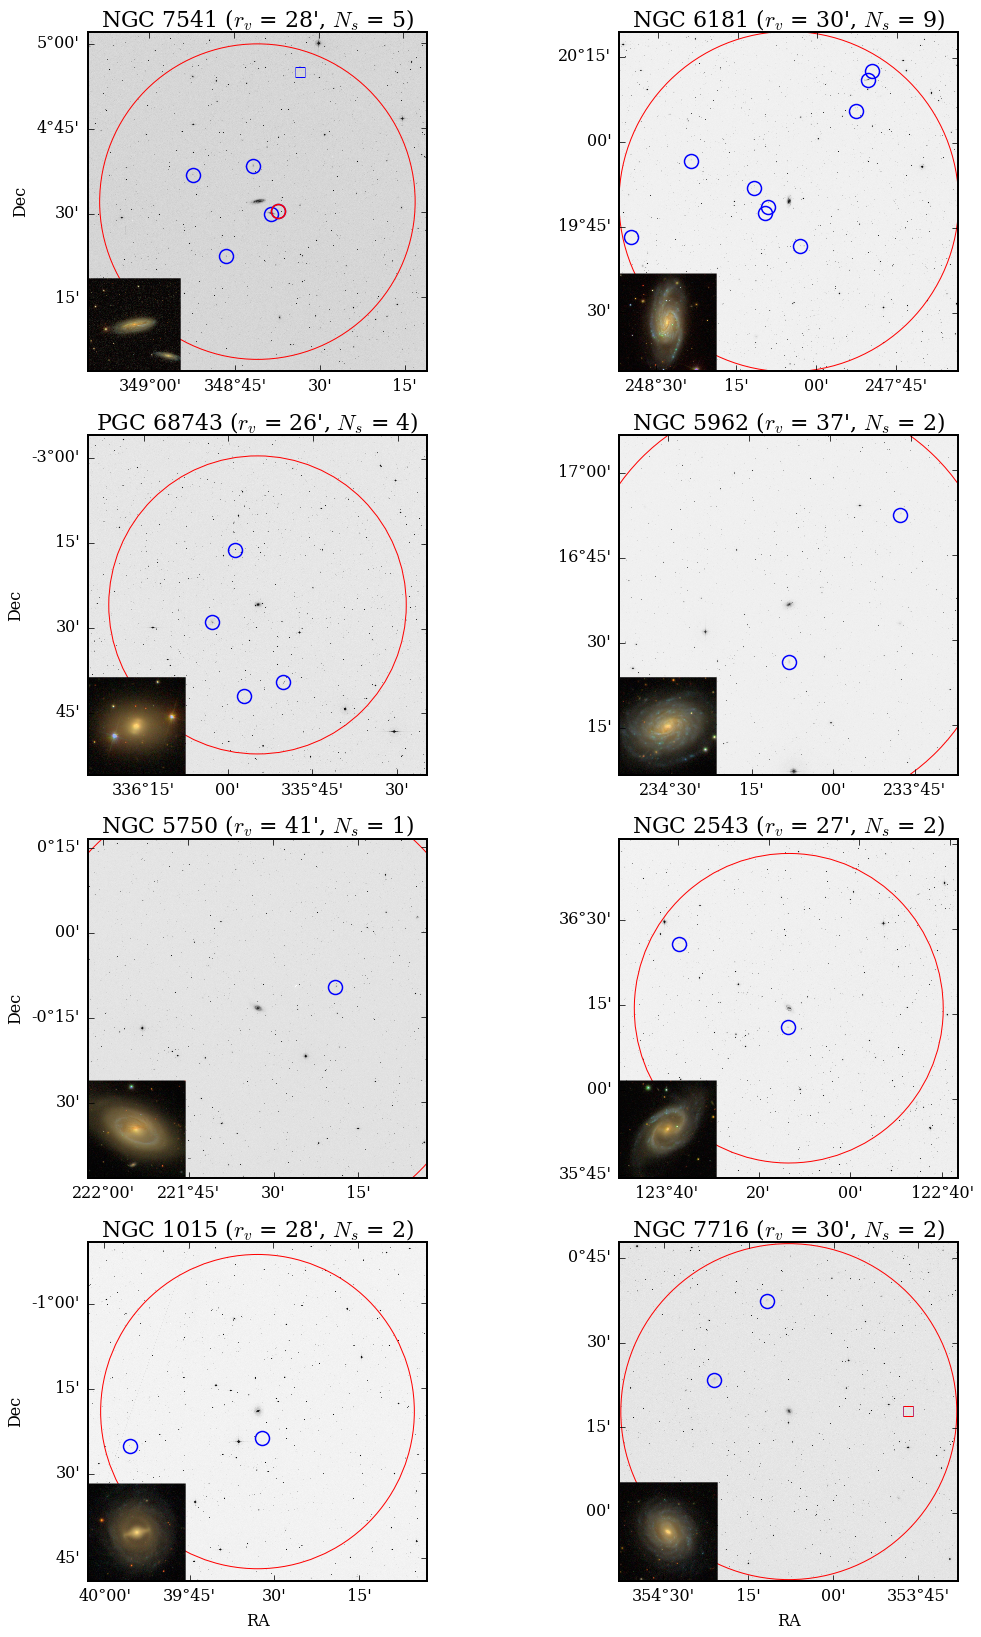

In [15]:
# PLOT EACH HOST
fig = plt.figure()
plt.rcParams['figure.figsize'] = 15, 22
plt.rcParams['font.size'] = 16.0

file = SAGA_DIR + '/data/sats.txt'
satsinfo = ascii.read(file)


# FIND OBJECTS BELOW LIMIT
r = allspec['r'] - allspec['EXTINCTION_R']
dmod = 5.*np.log10(1e6 * allspec['HOST_DIST']) - 5.
Mr = r - dmod
mlim = Mr < -12.3

for i,hosts in enumerate(complete_hosts):

    file = SAGA_DIR+'/images/NSA'+str(hosts)+'_60arcmin.fits'
    jpgfile = SAGA_DIR+'/images/'+str(hosts)+'.jpeg'

    m_host = allspec['HOST_NSAID'] == hosts
    sats = allspec[m_rmv & m_fib & m_gal & m_sats & m_host&mlim]
    fsats = allspec[m_rmv & m_fib & m_gal & m_sats & m_host&~mlim]

    
    
    ns=np.sum(m_rmv & m_fib & m_gal & m_sats & m_host&mlim)
    

    rvir = (180/np.pi)*np.arcsin(300./(sats['HOST_DIST'][0]*1000.))
    print hosts,rvir,ns
    hdu = fits.open(file)[0]
    w = wcs.WCS(hdu.header)

    # CREATE NGC NAME
    m_name = satsinfo['NSAID'] == hosts
    tmp = satsinfo[m_name]
    ngc = '{} {:d}'.format(tmp['NGCNAME'][0],int(tmp['NGC'][0]))
    print ngc    
    ns = int(tmp['Nsat'][0])    
        
    ax1 = fig.add_subplot(4, 2, i+1, projection=w)
    ax1.imshow(hdu.data,cmap='Greys')
    title = ngc + ' ($r_v$ = {:2.0f}\', $N_s$ = {:d})'.format(60.*rvir,ns)
    ax1.set_title(title,fontsize=22)
    ax1.plot(sats['RA'],sats['DEC'],'bo',transform=ax1.get_transform('fk5'),\
         ms = 14,markerfacecolor='none',markeredgecolor='b',mew=1.5)
  
    ax1.plot(fsats['RA'],fsats['DEC'],'bs',transform=ax1.get_transform('fk5'),\
             ms = 10,markerfacecolor='none',markeredgecolor='b')

    
    mabs = (sats['OBJID'] ==1237666408439677694) | (sats['OBJID']  ==1237679005021831801)
    fmabs = (fsats['OBJID'] ==1237666408439677694) | (fsats['OBJID']  ==1237679005021831801)
    print np.sum(mabs)
    if (np.sum(mabs) == 1):
        ax1.plot(sats['RA'][mabs],sats['DEC'][mabs],'ro',transform=ax1.get_transform('fk5'),\
         ms = 14,markerfacecolor='none',markeredgecolor='r',mew=1.5)
    if (np.sum(fmabs) == 1):
        ax1.plot(fsats['RA'][fmabs],fsats['DEC'][fmabs],'rs',transform=ax1.get_transform('fk5'),\
                 ms = 10,markerfacecolor='none',markeredgecolor='r')
    ax1.set_xlim(-0.5, hdu.data.shape[1] - 0.5)
    ax1.set_ylim(-0.5, hdu.data.shape[0] - 0.5)
    if (i == 0) |  (i==4) |  (i==2)|  (i==6):
        ax1.set_ylabel('Dec')
    if (i > 5):
        ax1.set_xlabel('RA')
    cs = np.abs(np.cos(sats['HOST_DEC'][0]*np.pi/180.))
    ce = Ellipse((sats['HOST_RA'][0], sats['HOST_DEC'][[0]]), 2*rvir/cs,2*rvir, edgecolor='r', facecolor='none',\
              transform=ax1.get_transform('fk5'))
    ax1.add_patch(ce)

    
    # ADD INSERT JPG
    img = mpimg.imread(jpgfile)
#    ax_inset = fig.add_axes((0, 0, 0.15, 0.15))
#    ax_inset.imshow(img)
#    ax_inset.axis('off')
    #    np.flipud(img)
    ax1.imshow(img,zorder=4)
    
plt.tight_layout(h_pad=4)
plt.savefig('fig_images.png',bbox_inches='tight')